Here we compare multicriterial selection for counterfactuals with single ones.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
import pickle
from rf_counterfactuals import RandomForestExplainer, visualize, evaluate_counterfactual, evaluate_counterfactual_set
from rf_counterfactuals.single_cf_costs_functions import heterogeneous_euclidean_overlap_metric, unmatched_components_distance
from rf_counterfactuals.multi_cf_costs_functions import diversity
import os
from collections import defaultdict

from sklearn import preprocessing
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, pairwise_distances
from sklearn.neighbors import NearestNeighbors
DATASET_PATH = "./datasets/"

N_JOBS = -1
N_ESTIMATORS = 100
MAX_DEPTH = 10

# Comment one of two cells below to choose a dataset

In [2]:
# DATASET_NAME = 'Adult'

# adult_dataset = pd.read_csv(os.path.join(DATASET_PATH, "adult.csv"))
# adult_dataset = adult_dataset.loc[:, adult_dataset.columns!='fnlwgt']

# class_feature = "income"
# feature_names = [c for c in adult_dataset.columns if c != class_feature]
# categorical_features = [1, 2, 4, 5, 6, 7, 8, 12]
# frozen_features = [7, 8]
# left_frozen_features = [0]
# to_encode = [c for no, c in enumerate(feature_names) if no in categorical_features]

# d = defaultdict(preprocessing.LabelEncoder)

# adult_dataset[to_encode] = adult_dataset[to_encode].apply(lambda x: d[x.name].fit_transform(x))

# X = adult_dataset.loc[:, adult_dataset.columns!=class_feature]
# y = adult_dataset[class_feature]

In [3]:
DATASET_NAME = 'German'

COLUMNS = ['checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount', 'saving_account', 'present_employement',
          'installment_rate', 'personal_status', 'other_debtors', 'present_residence', 'property', 'age', 'installment_plans',
          'housing', 'existing_credits_number', 'job', 'people_to_provide_maintenance', 'has_telephone', 'foreign', 'risk']

german_dataset = pd.read_csv(os.path.join(DATASET_PATH, "german_data.csv"), sep=' ', names=COLUMNS)

class_feature = "risk"
categorical_features = [0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]
frozen_features = [2]
left_frozen_features = [12]
to_encode = [c for no, c in enumerate(COLUMNS) if no in categorical_features]

d = defaultdict(preprocessing.LabelEncoder)

german_dataset[to_encode] = german_dataset[to_encode].apply(lambda x: d[x.name].fit_transform(x))

X = german_dataset.loc[:, german_dataset.columns!=class_feature]
y = german_dataset[class_feature]

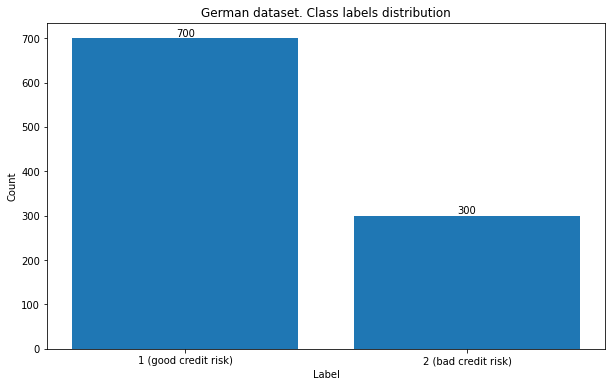

In [4]:
fig = plt.figure(figsize=(10, 6))
bars = plt.bar([0, 1], german_dataset[class_feature].value_counts()[german_dataset[class_feature].unique()])
fig.gca().bar_label(bars)
plt.xticks([0.0, 1], ['1 (good credit risk)', '2 (bad credit risk)'])
plt.xlabel("Label")
plt.ylabel("Count")
# plt.grid()
plt.title(f"{DATASET_NAME} dataset. Class labels distribution")
plt.show()

# Calculations

In [ ]:
from joblib import Parallel, delayed
from functools import partial

def calc_metrics(feature_range, cat, non_cat, X_primes, X):
    mean_hoem = np.mean([heterogeneous_euclidean_overlap_metric(X.values, X_prime.values, rfe.X_train_stats['range'],
                                                                  rfe.categorical_features,
                                                                  rfe.non_categorical_features) for _, X_prime in X_primes.iterrows()])
    
    d = diversity(X_primes, feature_range, cat, non_cat)
    return [mean_hoem, d]
   

CLASSES = y.unique()

SPLITS = 10

skf = StratifiedKFold(n_splits=SPLITS, shuffle=True, random_state=1000)
eps = 0.1


scores = defaultdict(list)

accuracy = []
split = 0

total_found = defaultdict(list)

for train_index, test_index in skf.split(X, y):
    start_time = time.time()
    print(split+1, "/", SPLITS)
    split += 1
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH)
    rf.fit(X_train, y_train)
    accuracy.append(accuracy_score(y_test, rf.predict(X_test)))

    
    X_test = X_test.sample(100)
    
    y_hat = rf.predict(X_test)
    X_test_0 = X_test[y_hat==CLASSES[0]]
    X_test_1 = X_test[y_hat==CLASSES[1]]

    
    rfe = RandomForestExplainer(rf, X_train, y_train, categorical_features=categorical_features, 
                                        left_frozen_features=left_frozen_features, frozen_features=frozen_features)
    
    
    cfs0 = rfe.explain_with_multiple_metrics(X_test_0, CLASSES[1], eps=eps, k=5, metrics=('hoem', 'unmatched_components'), n_jobs=N_JOBS)
    cfs1 = rfe.explain_with_multiple_metrics(X_test_1, CLASSES[0], eps=eps, k=5, metrics=('hoem', 'unmatched_components'), n_jobs=N_JOBS)

    found_0 = sum([1 for i in range(len(cfs0)) if len(cfs0[i]) >= 2])
    found_1 = sum([1 for i in range(len(cfs1)) if len(cfs1[i]) >= 2])
    
    total_found['0'] += [found_0, len(cfs0)]
    total_found['1'] += [found_1, len(cfs1)]
    
    print(f"found_0: {found_0} / {X_test_0.shape[0]}")
    print(f"found_1: {found_1} / {X_test_1.shape[0]}")
    
    
    rfe = RandomForestExplainer(rf, X_train, y_train, categorical_features=categorical_features, 
                                        left_frozen_features=left_frozen_features, frozen_features=frozen_features)
    
    cfs0_single_hoem = rfe.explain_with_single_metric(X_test_0, CLASSES[1], eps=eps, metric='hoem', k=5, limit=None, n_jobs=N_JOBS)
    cfs1_single_hoem = rfe.explain_with_single_metric(X_test_1, CLASSES[0], eps=eps, metric='hoem', k=5, limit=None, n_jobs=N_JOBS)
    
    rfe = RandomForestExplainer(rf, X_train, y_train, categorical_features=categorical_features, 
                                        left_frozen_features=left_frozen_features, frozen_features=frozen_features)
    
    cfs0_single_ucr = rfe.explain_with_single_metric(X_test_0, CLASSES[1], eps=eps, metric='unmatched_components', k=5, limit=None, n_jobs=N_JOBS)
    cfs1_single_ucr = rfe.explain_with_single_metric(X_test_1, CLASSES[0], eps=eps, metric='unmatched_components', k=5, limit=None, n_jobs=N_JOBS)

    results = Parallel(n_jobs=N_JOBS)(delayed(partial(calc_metrics, rfe.X_train_stats['range'],
                                                     rfe.categorical_features, rfe.non_categorical_features)
                                             )(cfs0[i], X_test_0.iloc[i]) for i in range(len(cfs0)) if len(cfs0[i]) >= 2)
    scores['multi0'].append(results)
    
    results = Parallel(n_jobs=N_JOBS)(delayed(partial(calc_metrics, rfe.X_train_stats['range'],
                                                     rfe.categorical_features, rfe.non_categorical_features)
                                             )(cfs1[i], X_test_1.iloc[i]) for i in range(len(cfs1)) if len(cfs1[i]) >= 2)
    scores['multi1'].append(results)

    
    results = Parallel(n_jobs=N_JOBS)(delayed(partial(calc_metrics, rfe.X_train_stats['range'],
                                                     rfe.categorical_features, rfe.non_categorical_features)
                                             )(cfs0_single_hoem[i].iloc[:len(cfs0[i])], X_test_0.iloc[i]) for i in range(len(cfs0)) if len(cfs0[i]) >= 2)
    scores['hoem0'].append(results)

    results = Parallel(n_jobs=N_JOBS)(delayed(partial(calc_metrics, rfe.X_train_stats['range'],
                                                     rfe.categorical_features, rfe.non_categorical_features)
                                             )(cfs1_single_hoem[i].iloc[:len(cfs1[i])], X_test_1.iloc[i]) for i in range(len(cfs1)) if len(cfs1[i]) >= 2)
    scores['hoem1'].append(results)
    
    results = Parallel(n_jobs=N_JOBS)(delayed(partial(calc_metrics, rfe.X_train_stats['range'],
                                                     rfe.categorical_features, rfe.non_categorical_features)
                                             )(cfs0_single_ucr[i].iloc[:len(cfs0[i])], X_test_0.iloc[i]) for i in range(len(cfs0)) if len(cfs0[i]) >= 2)
    scores['uc0'].append(results)
    
    results = Parallel(n_jobs=N_JOBS)(delayed(partial(calc_metrics, rfe.X_train_stats['range'],
                                                     rfe.categorical_features, rfe.non_categorical_features)
                                             )(cfs1_single_ucr[i].iloc[:len(cfs1[i])], X_test_1.iloc[i]) for i in range(len(cfs1)) if len(cfs1[i]) >= 2)
    scores['uc1'].append(results)
    

    print("Split time: ", time.time() - start_time, "s")

accuracy_mean, accuracy_std = np.mean(accuracy), np.std(accuracy)
accuracy_mean

1 / 10
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   22.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.9s finished


[3/3] Calculating loss function. Total number of tasks: 82


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  76 out of  82 | elapsed:   16.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  82 out of  82 | elapsed:   18.6s finished


[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:   26.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.9s finished


[3/3] Calculating loss function. Total number of tasks: 18


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:   10.5s remaining:   27.3s
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:   10.8s remaining:   17.0s
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:   18.1s remaining:   18.1s
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:   20.2s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   20.6s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:   20.9s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   24.8s finished


found_0: 12 / 82
found_1: 7 / 18
[1/3] Extracting positive paths.
[2/3] Generating counterfactual examples for each tree. Total number of tasks: 100


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.9s


In [ ]:
sum(total_found['0'][1::2])

In [ ]:
sum(total_found['1'][1::2])

In [ ]:
import itertools

scores2 = {}

for key, value in scores.items():
    score = np.array(list(itertools.chain.from_iterable(value)))
#     print(score)
    
    scores2[key] = score

scores2

In [ ]:
scores3 = {'multi': np.vstack([scores2['multi0'], scores2['multi1']]),
          'hoem': np.vstack([scores2['hoem0'], scores2['hoem1']]),
          'uc': np.vstack([scores2['uc0'], scores2['uc1']])
          }

In [ ]:
total_found_num = sum(total_found['0'][::2]) + sum(total_found['1'][::2])
total_found_denum = sum(total_found['0'][1::2]) + sum(total_found['1'][1::2])

total_found_num, total_found_denum, total_found_num * 100 /total_found_denum

In [ ]:
XLABELS = [f"pareto_optimal (hoem, u_c)", f"hoem", f"unmatched_components"]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
y_pos = np.arange(len(scores3.keys()))
means = np.array([np.mean(s, axis=0) for s in scores3.values()])
stds = np.array([np.std(s, axis=0) for s in scores3.values()])

width=0.45


plt.barh(y_pos, means[:, 0], width, xerr=stds[:, 0], label='mean_hoem (lower better)')
plt.barh(y_pos+width, means[:, 1], width, xerr=stds[:, 1], label='diversity (higher better)')

ax.set_yticks(y_pos, labels=XLABELS)
ax.legend()
ax.grid()
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Value')
ax.set_ylabel("Selection method")
ax.set_title(f"{DATASET_NAME} dataset, {SPLITS}-fold-cv. Evaluation of set with counterfactuals")

plt.show()

In [ ]:
for no, metric in enumerate(XLABELS):
    print(f"{metric} & {means[no, 0]:1.3f}({stds[no, 0]:1.3f}) & {means[no, 1]:1.3f}({stds[no, 1]:1.3f}) \\\\")